<a href="https://colab.research.google.com/github/jgdshkovi/Benn/blob/master/Copy_of_vgg_filter_cos_thes%3D0_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content/drive/My Drive/Z/filter_pruning

/content/drive/My Drive/Z/filter_pruning


In [0]:
import argparse
import numpy as np
from scipy.spatial import distance
import os

import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

from models import *
import spherical_kmeans_old as skm

cos = nn.CosineSimilarity()

In [0]:
test_batch_size = 256
dataset = 'cifar10'
cfg = [32, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 256, 256, 256, 'M', 256, 256, 256]
filtered_cfg = [16, 32, 'M', 64, 64, 'M', 128, 128, 128, 'M', 128, 128, 128, 'M', 128, 128, 128]
cuda = True

In [0]:
model = torch.load('L1_logs/model_best.pth.tar')
checkpoint = torch.load('L1_logs/checkpoint.pth.tar')

In [0]:
model = vgg(dataset='cifar10', depth=16,cfg=cfg)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [0]:
checkpoint.keys()
checkpoint.get('best_prec1')

tensor(0.9358)

In [0]:
def test(model):
    kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}
    if dataset == 'cifar10':
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('./data.cifar10', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
    elif dataset == 'cifar100':
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('./data.cifar100', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
        raise ValueError("No valid dataset is given.")
    model.eval()
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [0]:
from collections import defaultdict
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() if len(locs)>1)


def return_mask(wts, labels):
	modsource = labels.copy()
	#print(wts)
	#print(labels)
	for dup in sorted(list_duplicates(labels)):
	    #print(dup)
	    lis = dup[1][1:]
	    a = torch.from_numpy(np.reshape(wts[dup[1][0]],(1,wts[dup[1][0]].size)))
	    #a = wts[dup[1][0]]
	    for i in lis:
	    	b = torch.from_numpy(np.reshape(wts[i],(1,wts[i].size)))
	    	#print(i)
	    	simi = (cos(a,b))
	    	dis = distance.euclidean(a,b)
	    	#print(dis)
	    	#print(simi)
	    	if simi>0.25:
	    	  #print('....................')
	    	  modsource[i] = -1
	#print((modsource))
	mask = []
	for el in modsource:
		if el!=-1:
			mask.append(1)
		else:
			mask.append(0)
	#print((mask))
	return mask

def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

ress = []
z1 = []
z2 = []
def optimumk(X, shp):
  global ress,z1,z2
  z1 = z2 = []
  ress = []
  K = list(range(1,shp//2+1))
  K.append(shp)
  dist_points_from_cluster_center = []
  for no_of_clusters in K:
    res = skm.spherical_k_means(X,n_clusters=no_of_clusters,random_state=10)
    ress.append(res[1])
    dist_points_from_cluster_center.append(res[2])
    z1.append(no_of_clusters)

  a = dist_points_from_cluster_center[0] - dist_points_from_cluster_center[shp//2]
  b = K[shp//2] - K[0]
  c1 = K[0] * dist_points_from_cluster_center[shp//2]
  c2 = K[shp//2] * dist_points_from_cluster_center[0]
  c = c1 - c2
  #print(a,b,c)
  distance_of_points_from_line = []
  for k in range(shp//2+1):
    distance_of_points_from_line.append(
        calc_distance(K[k], dist_points_from_cluster_center[k], a, b, c))
  
  optk = distance_of_points_from_line.index(max(distance_of_points_from_line))
  z2 = dist_points_from_cluster_center
  #print(ress)
  #print(dist_points_from_cluster_center)
  return optk

def optk(X, shp):
  global ress,z1,z2
  z1 = z2 = []
  ress = []
  maxdis_k = 0
  iterations = 20*shp//100
  if iterations>50:
    iterations=50
  count = 1

  dist_points_from_cluster_center = [0]
  distance_of_points_from_line = [0]

  spt = skm.spherical_k_means(X,n_clusters=1,random_state=10)
  ept = skm.spherical_k_means(X,n_clusters=shp,random_state=10)

  a = spt[2] - ept[2]
  b = shp - 1
  c1 = 1 * ept[2]
  c2 = shp * spt[2]
  c = c1 - c2
  #print(a,b,c)
  z1.append(0)
  ress.append(spt[1])
  dist_points_from_cluster_center.append(spt[2])
  distance_of_points_from_line.append(
        calc_distance(1, dist_points_from_cluster_center[1], a, b, c))
  z1.append(1)

  for k in range(2,shp):
    if count<iterations:
      res = skm.spherical_k_means(X,n_clusters=k,random_state=10)
      ress.append(res[1])
      dist_points_from_cluster_center.append(res[2])
      dis = calc_distance(k, dist_points_from_cluster_center[k], a, b, c)
      distance_of_points_from_line.append(dis)
      z1.append(k)
      if dis > distance_of_points_from_line[maxdis_k]:
        maxdis_k = k
        count = 0
      else:
        count += 1
    else:
      break

  ress.append(ept[1])
  dist_points_from_cluster_center.append(ept[2])
  distance_of_points_from_line.append(
        calc_distance(shp, dist_points_from_cluster_center[-1], a, b, c))
  z1.append(shp)
  z2 = dist_points_from_cluster_center
  #plt.plot(list(range(1,shp+1)),dist_points_from_cluster_center)
  return maxdis_k

def return_cluster_labels(feat_wts, shp):  #no_of_clus):
  #res = skm.spherical_k_means(feat_wts,n_clusters=no_of_clus,random_state=10)
  #return res[1]

  k = optk(feat_wts, shp)
  print(k)
  #print(ress[k])
  #print(ress[10])
  return ress[k] #= skm.spherical_k_means(feat_wts,n_clusters=k,random_state=10)

[]


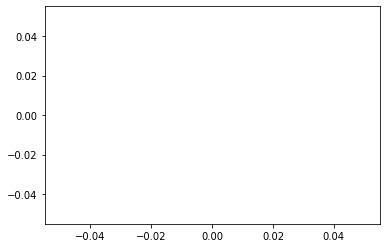

In [0]:
plt.plot(z1[1:],z2[1:])
print(z2)

In [0]:
plt.plot(z1[1:],z2[1:])
print(z2)

torch.Size([32, 3, 3, 3])
10
24


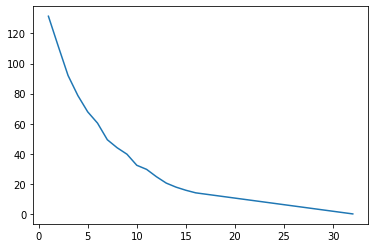

torch.Size([64, 32, 3, 3])
14
41


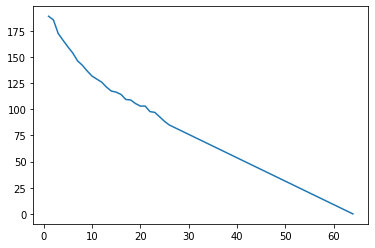

torch.Size([128, 64, 3, 3])
23
83


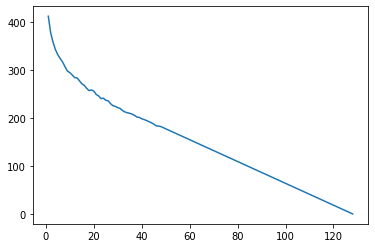

torch.Size([128, 128, 3, 3])
23
121


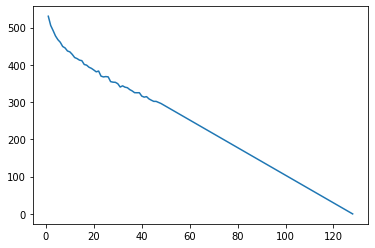

torch.Size([256, 128, 3, 3])
33
251


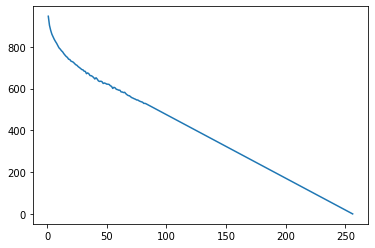

torch.Size([256, 256, 3, 3])
53
235


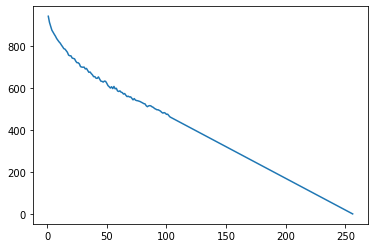

torch.Size([256, 256, 3, 3])
52
229


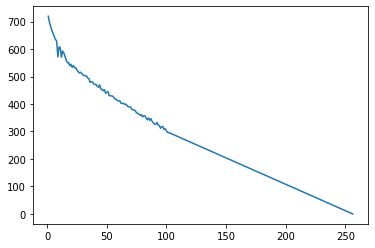

torch.Size([256, 256, 3, 3])
61
169


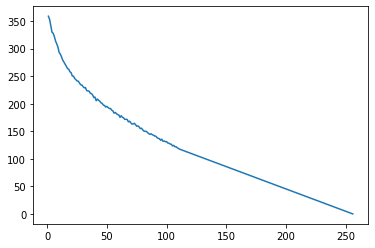

torch.Size([256, 256, 3, 3])
58
126


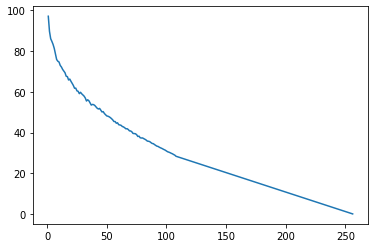

torch.Size([256, 256, 3, 3])
71
118


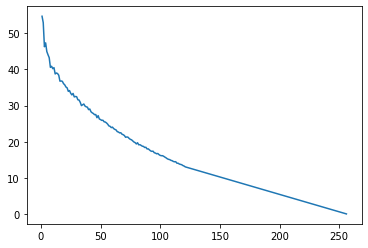

torch.Size([256, 256, 3, 3])
47
53


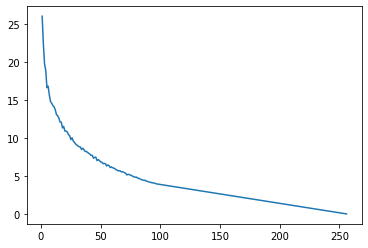

torch.Size([256, 256, 3, 3])
41
57


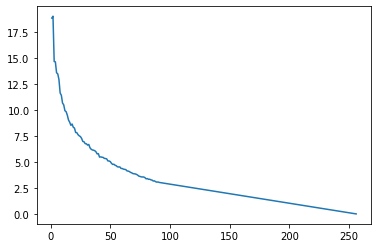

torch.Size([256, 256, 3, 3])
46
60


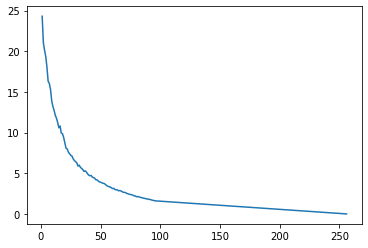

[24, 41, 'M', 83, 121, 'M', 251, 235, 229, 'M', 169, 126, 118, 'M', 53, 57, 60]


In [0]:
cos_cfg = []
cfg_mask = []
layer_id = 0
for m in model.modules():
  if isinstance(m , nn.Conv2d):
    shape = m.weight.data.shape
    print(shape)
    reshaped_tensor = m.weight.data.clone().numpy().reshape(shape[0] , shape[1]*shape[2]*shape[3])

    labels = return_cluster_labels(reshaped_tensor,shape[0])  #filtered_cfg[layer_id])
    #print(labels)
    mask = return_mask(reshaped_tensor,labels)
    #print(mask)
    print(sum(mask))
    cos_cfg.append(sum(mask))
    cfg_mask.append(torch.tensor(mask))
    layer_id += 1
    
    plt.plot(z1[1:],z2[1:])
    plt.show()
    #break
  elif isinstance(m, nn.MaxPool2d):
    layer_id += 1
    cos_cfg.append('M')
  #if layer_id>3:
    #break
print(cos_cfg)

In [0]:
[24, 41, 'M', 83, 121, 'M', 251, 235, 229, 'M', 169, 126, 118, 'M', 53, 57, 60] --- thres=0.5

In [0]:
print(cos_cfg)

[26, 32, 'M', 64, 64, 'M', 64, 128, 128, 'M', 128, 127, 124, 'M', 62, 57, 63]


In [0]:
cos = nn.CosineSimilarity()

In [0]:
a = torch.from_numpy(np.reshape(X[0],(1,X[0].size)))
b = torch.from_numpy(np.reshape(X[5],(1,X[5].size)))


In [0]:
newmodel = vgg(dataset = 'cifar10' ,cfg=cos_cfg)
newmodel.cuda()

start_mask = torch.ones(3)
layer_id_in_cfg = 0
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))
        m1.weight.data = m0.weight.data[idx1.tolist()].clone()
        m1.bias.data = m0.bias.data[idx1.tolist()].clone()
        m1.running_mean = m0.running_mean[idx1.tolist()].clone()
        m1.running_var = m0.running_var[idx1.tolist()].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        if idx1.size == 1:
            idx1 = np.resize(idx1, (1,))
        w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
        w1 = w1[idx1.tolist(), :, :, :].clone()
        m1.weight.data = w1.clone()
    elif isinstance(m0, nn.Linear):
        if layer_id_in_cfg == len(cfg_mask):
            idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            m1.weight.data = m0.weight.data[:, idx0].clone()
            m1.bias.data = m0.bias.data.clone()
            layer_id_in_cfg += 1
            continue
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()
    elif isinstance(m0, nn.BatchNorm1d):
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()
        m1.running_mean = m0.running_mean.clone()
        m1.running_var = m0.running_var.clone()

In shape: 3, Out shape 26.
In shape: 26, Out shape 32.
In shape: 32, Out shape 64.
In shape: 64, Out shape 64.
In shape: 64, Out shape 64.
In shape: 64, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 128.
In shape: 128, Out shape 127.
In shape: 127, Out shape 124.
In shape: 124, Out shape 62.
In shape: 62, Out shape 57.
In shape: 57, Out shape 63.


In [0]:
torch.save({'cfg': cos_cfg, 'state_dict': newmodel.state_dict()},'Test_logs/pruned.pth.tar')
print(newmodel)
model = newmodel
model.cuda()
acc = test(model)

num_parameters = sum([param.nelement() for param in newmodel.parameters()])
with open( "Test_logs/prune.txt", "w") as fp:
    fp.write("Number of parameters: \n"+str(num_parameters)+"\n")
    fp.write("Test accuracy: \n"+str(acc)+"\n")

vgg(
  (feature): Sequential(
    (0): Conv2d(3, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(26, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [0]:
!python main_finetune.py --refine Filter_logs/pruned.pth.tar --dataset cifar10 --epochs 10 --save Filter_logs/

Files already downloaded and verified
Train Epoch: 0 [0/50000 (0.0%)]	Loss: 3.237350
Train Epoch: 0 [6400/50000 (12.8%)]	Loss: 0.726783
Train Epoch: 0 [12800/50000 (25.6%)]	Loss: 0.547180
Train Epoch: 0 [19200/50000 (38.4%)]	Loss: 0.646843
Train Epoch: 0 [25600/50000 (51.2%)]	Loss: 0.271935
Train Epoch: 0 [32000/50000 (63.9%)]	Loss: 0.413913
Train Epoch: 0 [38400/50000 (76.7%)]	Loss: 0.418347
Train Epoch: 0 [44800/50000 (89.5%)]	Loss: 0.522038
main_finetune.py:153: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test set: Average loss: 0.4774, Accuracy: 8480/10000 (84.8%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.342160
Train Epoch: 1 [6400/50000 (12.8%)]	Loss: 0.275073
Train Epo